# __Apple stock price forecasting (AAPL)__

Set working directory to Trading_Recommender folder

In [1]:
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statements

In [2]:
from src.data.extract_dataset import extract_financial_data
from src.features.extend_dataset import compute_technical_indicators, merge_dataframes, get_target
from src.features.feature_selection import select_features, evaluate_features
from src.features.feature_engineering import engineer_features, scale_dataframe, get_final_dataframe
from src.forecast.forecaster import forecaster
from src.forecast.recommender import recommender
from src.tuning.optuna_tuning import optuna_search
import optuna_dashboard
from optuna.storages import JournalStorage, JournalFileStorage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from itertools import accumulate
from copy import deepcopy

Invoking __init__.py for src
Invoking __init__.py for src.data
Invoking __init__.py for src.models
Invoking __init__.py for src.models.LSTM_files
Invoking __init__.py for src.forecast
Invoking __init__.py for src.tuning
Invoking __init__.py for src.features


In [3]:
stock_name = 'AAPL'

Extract the data from locally saved files. There is also an option to download stock market data from yfinance

The raw data that will be used can be classified into three categories:  
1) Stock market data (Open, Close, High, Low, Volume)  
2) SMIS macro-economic indicators (^IXIC, ^GSPC, DJI)  
3) Internet trend data (googletrends, wikipediatrends)  

In [4]:
stock_dict, smis_dict, trend_dict = extract_financial_data(data_dir = 'data', 
                                                           save=False, online=False)
stock = stock_dict[stock_name]
close = stock[['Close']]

Extend the raw features by computing a large number technical indicators using pandas-ta

In [5]:
stock_extended, smis_extended, trend_extended = compute_technical_indicators(stock,
                                                                             deepcopy(smis_dict),
                                                                             deepcopy(trend_dict[stock_name]))

These various types of data will now be merged into only one pandas dataframe

In [6]:
extended_df_withna = merge_dataframes(stock_extended, smis_extended, trend_extended)
extended_df = extended_df_withna.dropna()

Check the number of technical features

In [7]:
print(f'Number of features: {extended_df.shape[1]}')

Number of features: 275


Check the number of rows and the date range

In [8]:
print(f'Number of days: {extended_df.shape[0]}\nDate Range: from {extended_df.index[0]}  to  {extended_df.index[-1]}')

Number of days: 1469
Date Range: from 2020-04-23 00:00:00  to  2024-04-30 00:00:00


Next, a feature selection will be performed using sktime.  
This will be based on whether the selected features are informative enough to predict the binary labels y.  
The labels indicate for each row whether the stock price will be increasing or decreasing {horizon} days into the future

In [9]:
horizon = 14 # How many days ahead do we want to forecast the stock price evolution
target = get_target(extended_df,
                    horizon) # This is the return defined as Close[i+horizon]/Close[i] - 1
y = (target>0).astype(int)

In the next cell, a much smaller number of relevant features are selected

In [10]:
regressor = GradientBoostingRegressor(max_depth=1)
features_selected, feature_importances = select_features(extended_df,
                                                         horizon = horizon,
                                                         n_columns = None,
                                                         regressor = regressor,
                                                         importance_threshold = 0.99)
feature_names = list(features_selected.columns)
# Printing information about the selected features
print(f'Using {regressor = }, only {features_selected.shape[1]} features are selected')
print(f'The selected features with {horizon = } are: \n{feature_names}')
print(f'With a cumulated relative importance of {sum(map(lambda item: item[1], feature_importances))}')

Using regressor = GradientBoostingRegressor(max_depth=1), only 27 features are selected
The selected features with horizon = 14 are: 
['DPO_20', 'CKSPs_10_3_20', 'QS_10', 'J_9_3', 'ICS_26', 'PVT', 'ZS_30', 'SMIo_5_20_5', 'CKSPl_10_3_20', 'CCI_14_0.015', 'KVO_34_55_13', 'FWMA_10', 'VAR_30', 'ACCBL_20', 'RVI_14', 'TSIs_13_25_13', '^GSPC_FWMA_10', 'googletrends_Apple_news_DPO_20', 'AR_26', 'wikitrends_MacBook_ALMA_10_6.0_0.85', 'googletrends_iphone_shopping_MOM_10', 'googletrends_iphone_shopping_DPO_20', 'PVOs_12_26_9', 'googletrends_Apple_news_MOM_10', 'STOCHk_14_3_3', '^GSPC_DPO_20', 'SUPERTs_7_3.0']
With a cumulated relative importance of 0.9999999999999998


The selected features predictive power are evaluated using the Rocket(num_kernels=2000) and HIVECOTEV2(time_limit_in_minutes=0.4) classifier instances

In [11]:
selected_df, _ = get_final_dataframe(features_selected,
                                     target) # Concatenates features_selected with target named as Return, and scales the dataframe
untransformed_result = evaluate_features(selected_df.drop(columns=['Return']), y)
untransformed_accuracies = (untransformed_result['HIVECOTEV2_accuracy'],
                            untransformed_result['Rocket_accuracy'])
print(f'The HIVECOTEV2 and Rocket classifiers respective accuracies using the {features_selected.shape[1]} untransformed features are: {untransformed_accuracies}')

The HIVECOTEV2 and Rocket classifiers respective accuracies using the 27 untransformed features are: (0.736986301369863, 0.7123287671232876)


In [12]:
for key, value in untransformed_result.items():
    print(f'{key} = {value}')

Rocket_accuracy = 0.7123287671232876
Rocket_precision = 0.5844155844155844
Rocket_recall = 0.9375
Rocket_specificity = 0.5656108597285068
Rocket_f1_score = 0.7200000000000001
Rocket_confusion_matrix = [[125  96]
 [  9 135]]
HIVECOTEV2_accuracy = 0.736986301369863
HIVECOTEV2_precision = 0.6153846153846154
HIVECOTEV2_recall = 0.8888888888888888
HIVECOTEV2_specificity = 0.6380090497737556
HIVECOTEV2_f1_score = 0.7272727272727274
HIVECOTEV2_confusion_matrix = [[141  80]
 [ 16 128]]


Next, the selected features are transformed using the Principal Component Analysis algorithm  
The engineered features predictive power are evaluated using the Rocket(num_kernels=2000) and HIVECOTEV2(time_limit_in_minutes=0.2) classifier instances

In [13]:
variance_threshold = 0.9
features_engineered, transformer = engineer_features(features_selected, 
                                                     variance_threshold)
engineered_df, scalers = get_final_dataframe(features_engineered,
                                             target) # Concatenates features_engineered with target named as Return, and scales the dataframe
data_scaler, target_scaler = scalers

transformed_result = evaluate_features(engineered_df.drop(columns=['Return']), y)
transformed_accuracies = (transformed_result['HIVECOTEV2_accuracy'],
                          transformed_result['Rocket_accuracy'])
print(f'The HIVECOTEV2 and Rocket classifiers respective accuracies using the {features_engineered.shape[1]} transformed features are: {transformed_accuracies}')


Only 10 features are extracted from the PCA with a total relative variance of 0.9014471218002756/1



C:\ProgramData\anaconda3\Lib\site-packages\sktime\classification\dictionary_based\_tde.py:263: UserWarning: TemporalDictionaryEnsemble warning: min_window = 10 is larger than max_window = 10. min_window has been set to 10.
  warn(


The HIVECOTEV2 and Rocket classifiers respective accuracies using the 10 transformed features are: (0.7589041095890411, 0.7972602739726027)


Despite the fact that the 10 engineered features only reflect about 92% of the variance of the original 24 selected features, the classifiers perform better with these engineered features

In [14]:
for key, value in transformed_result.items():
    print(f'{key} = {value}')

Rocket_accuracy = 0.7972602739726027
Rocket_precision = 0.6732673267326733
Rocket_recall = 0.9444444444444444
Rocket_specificity = 0.7013574660633484
Rocket_f1_score = 0.786127167630058
Rocket_confusion_matrix = [[155  66]
 [  8 136]]
HIVECOTEV2_accuracy = 0.7589041095890411
HIVECOTEV2_precision = 0.6320754716981132
HIVECOTEV2_recall = 0.9305555555555556
HIVECOTEV2_specificity = 0.6470588235294118
HIVECOTEV2_f1_score = 0.7528089887640449
HIVECOTEV2_confusion_matrix = [[143  78]
 [ 10 134]]


Next, some information on the engineered features

In [15]:
covariance = transformer.get_covariance()
explained_variance = transformer.explained_variance_/sum(transformer.explained_variance_)
components = transformer.components_[:features_engineered.shape[1], :]
contributions = np.abs(components)/np.sum(np.abs(components), axis = 1, keepdims=True)
contributions_df = pd.DataFrame(contributions, columns=features_selected.columns, index=[f'PC {i+1} (Variance {explained_variance[i]:.4f})' for i in range(components.shape[0])])
contributing_features = [sorted([(contributions_df.columns[i], value) for i, value in enumerate(contributions_df.iloc[j])], key = lambda x:x[1], reverse=True) for j in range(contributions_df.shape[0])]

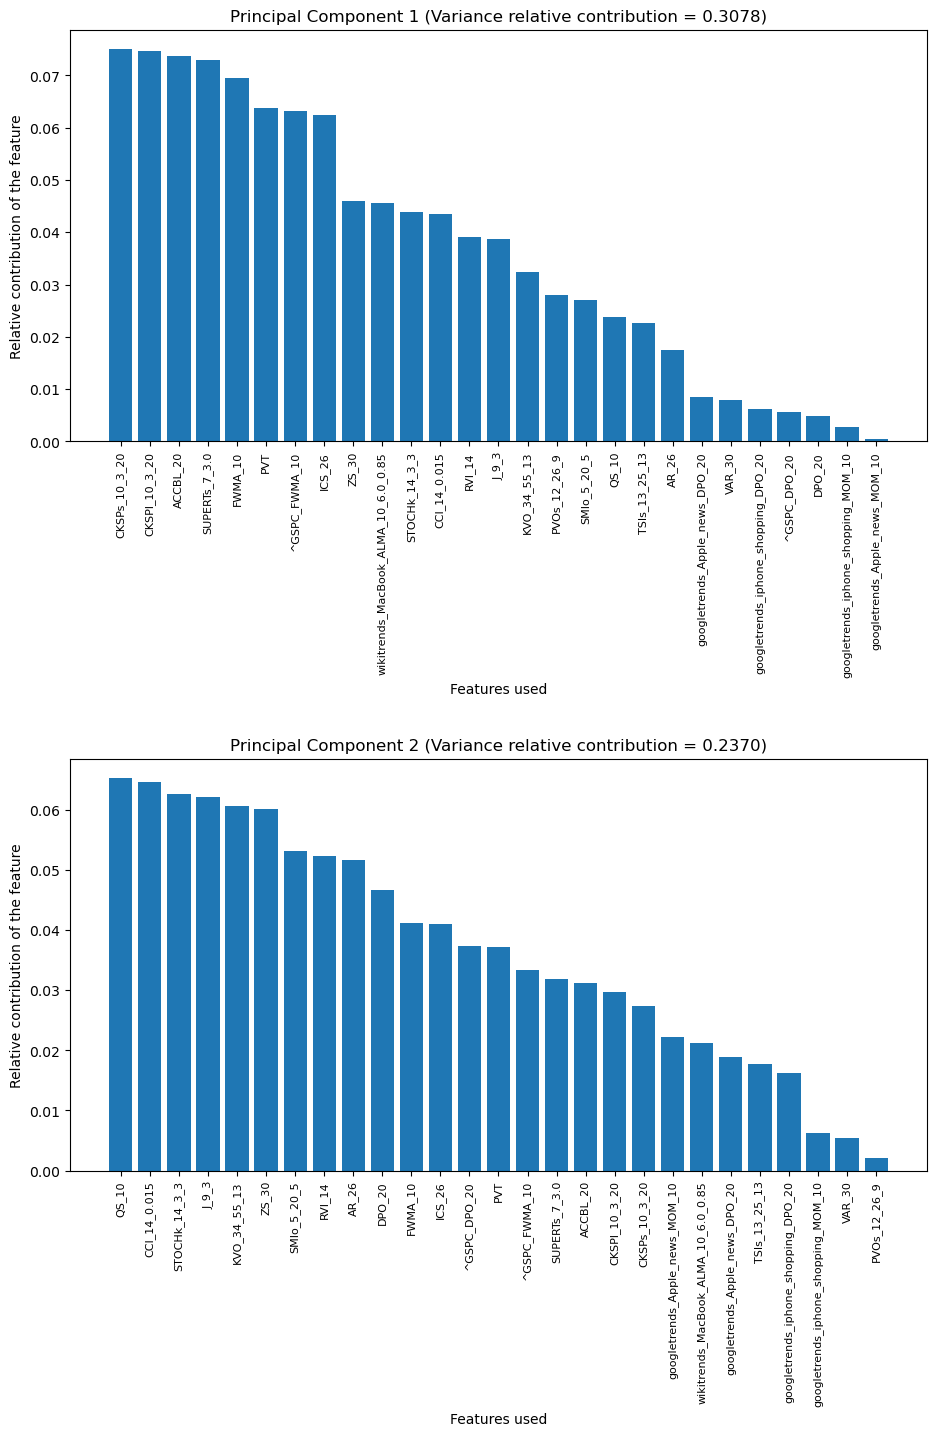

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))

for i, component in enumerate(contributing_features[:2]):
    features = [x[0] for x in component]
    values = [x[1] for x in component]

    axs[i].bar(features, values)
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].set_title(f'Principal Component {i+1} (Variance relative contribution = {explained_variance[i]:.4f})')
    axs[i].set_xlabel('Features used')
    axs[i].set_ylabel('Relative contribution of the feature')

plt.tight_layout(pad=3)
plt.show()

It can be noted that: 
- The two main Principal Components hold more than half of the total variance
- Some SMIS macroeconomic indicators (^IXIC, ^GSPC) contribute significantly to the two main Principal Components
- Statistics on searched keywords like Amazon and AmazonPrime on Google and Wikipedia also contribute to the two main Principal Components

In [17]:
engineered_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Return
DateTime,,,,,,,,,,,
2020-04-23,2.623615,1.869681,0.020901,-0.176934,-0.698365,-0.855057,0.782794,-0.544739,1.549235,-0.020355,1.742645
2020-04-24,2.770338,1.464691,0.333909,-0.377690,-0.630837,-0.998869,0.648527,-0.616773,1.447026,-0.017054,1.642296
2020-04-25,2.772510,1.388612,0.407513,-0.408383,-0.557904,-1.024427,0.661424,-0.846194,1.212011,-0.166323,1.743833
2020-04-26,2.795978,1.324662,0.471585,-0.457933,-0.531613,-1.106640,0.630278,-0.889797,1.175245,-0.248712,1.845323
2020-04-27,2.838219,1.266486,0.487196,-0.557623,-0.519194,-1.250513,0.563581,-0.766687,1.282965,-0.282755,1.946765


In [18]:
engineered_df.tail()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Return
DateTime,,,,,,,,,,,
2024-04-12,-0.360594,-1.711654,0.201062,-1.732266,-0.894414,-0.476237,-0.034116,0.280430,-0.368341,-0.064721,-0.940759
2024-04-13,-0.445342,-1.566084,0.132355,-1.658547,-0.879977,-0.440567,-0.237236,0.134960,-0.387785,-0.067782,-0.663517
2024-04-14,-0.515824,-1.412389,0.057264,-1.597459,-0.896787,-0.442850,-0.469861,0.113971,-0.274422,-0.026040,-0.382174
2024-04-15,-0.577480,-1.239385,0.058956,-1.545767,-0.854292,-0.609724,-0.475963,0.246294,-0.085489,-0.068540,-0.096639
2024-04-16,-0.893060,-0.501281,-0.050785,-1.463771,-0.656652,-1.060251,-0.913030,0.482553,0.399698,-0.776730,0.265571


Now, the features are fully processed.
Next, the hyperparameters of a LSTM model will be tuned using optuna to forecast the stock prices.  
First, the arguments necessary for the study will be defined.

Data arguments

In [19]:
data_args = {'features': engineered_df,
             'close': close,
             'f_scaler': data_scaler,
             't_scaler': target_scaler,
             'symbol': stock_name}

Temporal arguments

In [20]:
start_date = pd.to_datetime('2023-03-01')
end_date = pd.to_datetime('2023-12-31')
temporal_args = {'start_date': start_date,
                 'end_date': end_date,
                 'horizon': horizon,
                 'plot_start_date': pd.to_datetime('2023-01-01')}

Model choice (LSTM) and default model parameters

In [21]:
predictor_name = 'LSTM'
model_args = {'seq_len': 30,
              'learning_rate': 0.001,
              'loss': 'mse',
              'n_a': 16,
              'dropout': 0.05,
              'stateful_training': False,
              'stateful_inference': False,
              'horizon': horizon}

Training parameters

In [22]:
training_args = {'epochs': 100,
                 'batch_size': 32,
                 'shuffle': False,
                 'verbose': 0}

Trading parameters (for the simulation)

In [23]:
initial_stock = 1
max_trade = 1
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_rate = 0.001 # Minimum daily rate of relative price change to trigger trading action
trading_args = {'initial_stock': initial_stock,
                'max_trade': max_trade,
                'intensity': intensity,
                'min_delta': min_rate*horizon}

Launching the hyperparameter search with an optuna study.

C:\Users\GEOFF\AppData\Local\Temp\ipykernel_5692\27117782.py:7: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(f"src/tuning/{storage_name}.log"))
[I 2024-05-25 16:53:11,605] A new study created in Journal with name: LSTM_ahead=14


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0995 - mean_absolute_error: 0.2275
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0950 - mean_absolute_error: 0.2278
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1363 - mean_absolute_error: 0.2581
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1283 - mean_absolute_error: 0.2573
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1088 - mean_absolute_error: 0.2366
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0925 - mean_absolute_error: 0.2249
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1064 - mean_absolute_error: 0.2336
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0819 - mean_absolute_error: 0.2075
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2949 - mean_absolute_error: 0.3355
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1220 - mean_absolute_error: 0.2495
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1081 - mean_absolute_error: 0.2431
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1088 - mean_absolute_error

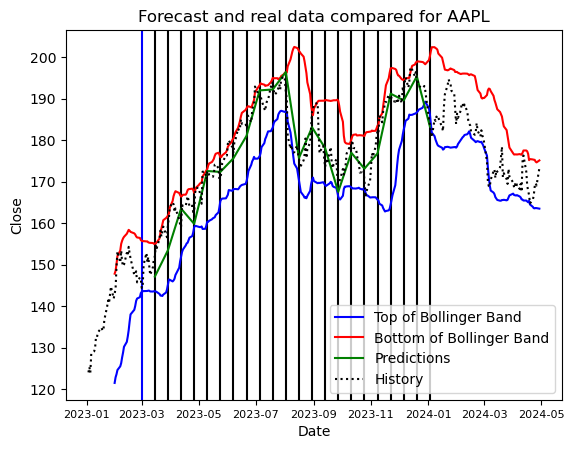

[I 2024-05-25 17:23:37,921] Trial 0 finished with value: 10.205956588163714 and parameters: {'n_a': 36, 'learning_rate': 0.0026938830192854116, 'seq_len': 73, 'dropout': 0.10897663659937938}. Best is trial 0 with value: 10.205956588163714.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1280 - mean_absolute_error: 0.2596 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1428 - mean_absolute_error: 0.2790 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1096 - mean_absolute_error: 0.2501
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1174 - mean_absolute_error: 0.2559
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1292 - mean_absolute_error: 0.2652 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1329 - mean_absolute_error: 0.2591 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1376 - mean_absolute_error: 0.2743
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1275 - mean_absolute_error: 0.2611 
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1256 - mean_absolute_error: 0.2750
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1189 - mean_absolute_error: 0.2588
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1123 - mean_absolute_error: 0.2486
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1854 - mean_absolute_e

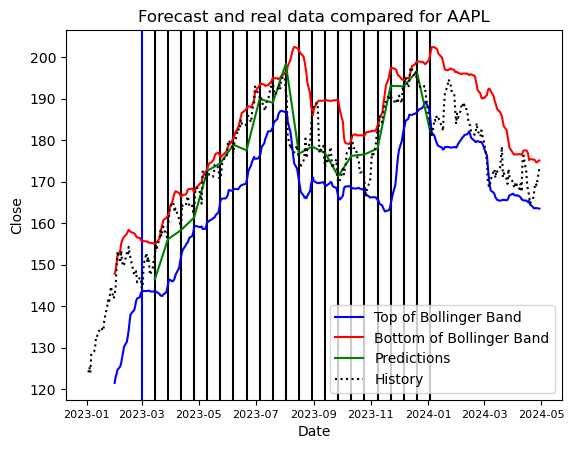

[I 2024-05-25 17:42:53,519] Trial 1 finished with value: 15.420728195702017 and parameters: {'n_a': 28, 'learning_rate': 0.0019578897201213002, 'seq_len': 53, 'dropout': 0.17835460015641597}. Best is trial 0 with value: 10.205956588163714.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1093 - mean_absolute_error: 0.2459
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1019 - mean_absolute_error: 0.2416
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1029 - mean_absolute_error: 0.2378
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1055 - mean_absolute_error: 0.2430
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1214 - mean_absolute_error: 0.2561
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1093 - mean_absolute_error: 0.2477
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1012 - mean_absolute_error: 0.2430
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1081 - mean_absolute_error: 0.2393
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1093 - mean_absolute_error: 0.2462
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1089 - mean_absolute_error: 0.2491
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1022 - mean_absolute_error: 0.2380
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1029 - mean_abs

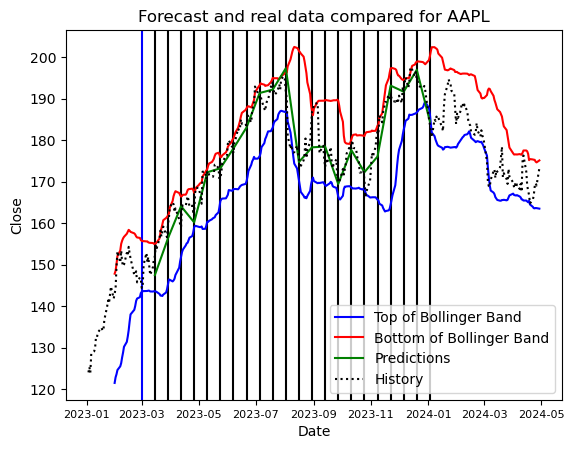

[I 2024-05-25 18:20:09,582] Trial 2 finished with value: 12.53417808391052 and parameters: {'n_a': 62, 'learning_rate': 0.0005846326121643416, 'seq_len': 96, 'dropout': 0.1057789839505809}. Best is trial 0 with value: 10.205956588163714.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - mean_absolute_error: 0.1593  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 - mean_absolute_error: 0.1429  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 - mean_absolute_error: 0.1692  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0536 - mean_absolute_error: 0.1646  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0572 - mean_absolute_error: 0.1786  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0642 - mean_absolute_error: 0.1724   
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 - mean_absolute_error: 0.1660  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530 - mean_absolute_error: 0.1787  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0617 - mean_absolute_error: 0.1858  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0507 - mean_absolute_error: 0.1637  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - mean_absolute_error: 0.1528  
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504

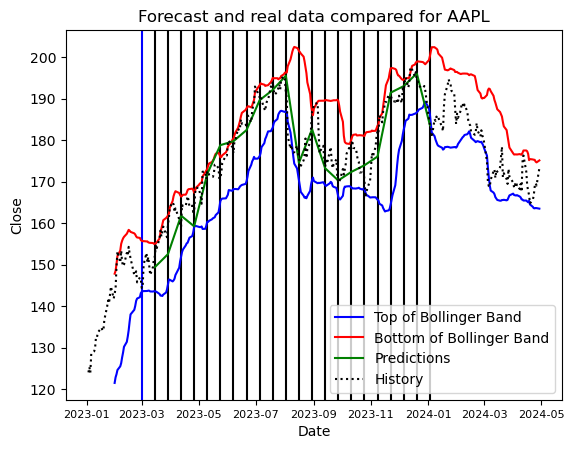

[I 2024-05-25 18:26:26,737] Trial 3 finished with value: 13.74822243618499 and parameters: {'n_a': 37, 'learning_rate': 0.007098936257405904, 'seq_len': 9, 'dropout': 0.017425859940308142}. Best is trial 0 with value: 10.205956588163714.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3412 - mean_absolute_error: 0.4529 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3085 - mean_absolute_error: 0.4383 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3807 - mean_absolute_error: 0.4749
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3533 - mean_absolute_error: 0.4658 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4340 - mean_absolute_error: 0.5053 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3600 - mean_absolute_error: 0.4678  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3790 - mean_absolute_error: 0.4725
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3757 - mean_absolute_error: 0.4833
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3993 - mean_absolute_error: 0.4937 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4203 - mean_absolute_error: 0.4962 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3395 - mean_absolute_error: 0.4645
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4122 - mean_absolut

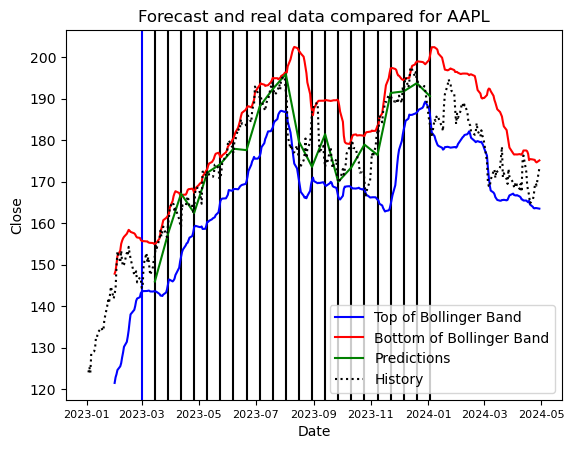

[I 2024-05-25 18:44:10,123] Trial 4 finished with value: 27.049863755998445 and parameters: {'n_a': 2, 'learning_rate': 0.0046263628414755864, 'seq_len': 94, 'dropout': 0.17400242964936385}. Best is trial 0 with value: 10.205956588163714.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0860 - mean_absolute_error: 0.2205
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1698 - mean_absolute_error: 0.2732
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0948 - mean_absolute_error: 0.2192
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1003 - mean_absolute_error: 0.2374
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1009 - mean_absolute_error: 0.2345
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1093 - mean_absolute_error: 0.2422
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1001 - mean_absolute_error: 0.2351
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0902 - mean_absolute_error: 0.2227
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0900 - mean_absolute_error: 0.2238
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2567 - mean_absolute_error: 0.3204
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0988 - mean_absolute_error: 0.2329
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1102 - mean_absolute_error:

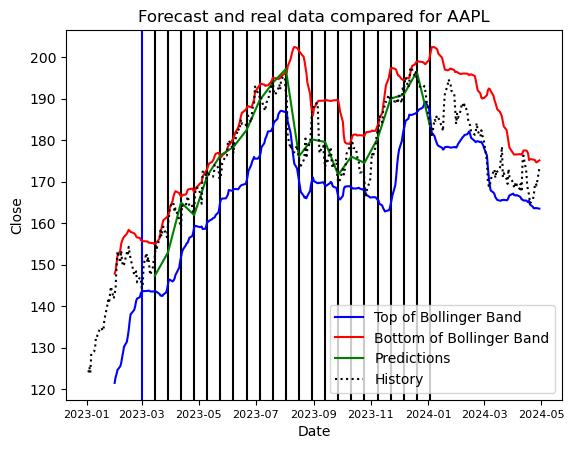

[I 2024-05-25 19:09:48,349] Trial 5 finished with value: 13.717931538660599 and parameters: {'n_a': 63, 'learning_rate': 0.00396567508177101, 'seq_len': 56, 'dropout': 0.1561058352572911}. Best is trial 0 with value: 10.205956588163714.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1909 - mean_absolute_error: 0.3325 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2179 - mean_absolute_error: 0.3563  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2427 - mean_absolute_error: 0.3697  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2297 - mean_absolute_error: 0.3662  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2137 - mean_absolute_error: 0.3529  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1951 - mean_absolute_error: 0.3349  
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1921 - mean_absolute_error: 0.3324  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1906 - mean_absolute_error: 0.3335  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1908 - mean_absolute_error: 0.3333  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 - mean_absolute_error: 0.3321  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2407 - mean_absolute_error: 0.3646  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2089 -

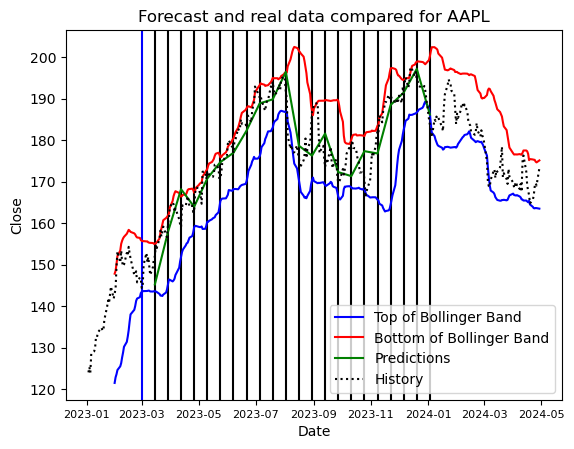

[I 2024-05-25 19:16:44,184] Trial 6 finished with value: 25.651621579184727 and parameters: {'n_a': 8, 'learning_rate': 0.001904767808428205, 'seq_len': 18, 'dropout': 0.1889337834099168}. Best is trial 0 with value: 10.205956588163714.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1202 - mean_absolute_error: 0.2632  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1204 - mean_absolute_error: 0.2631  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1322 - mean_absolute_error: 0.2778  
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1184 - mean_absolute_error: 0.2618 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1267 - mean_absolute_error: 0.2698 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1393 - mean_absolute_error: 0.2689 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1279 - mean_absolute_error: 0.2638 
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1200 - mean_absolute_error: 0.2608 
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1175 - mean_absolute_error: 0.2618 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1226 - mean_absolute_error: 0.2661 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1226 - mean_absolute_error: 0.2684 


In [ ]:
hyperparameter_search = True
num_trials = 50 # If the study already exists, it will be continued with {num_trials} new trials
if hyperparameter_search:
    study_name = f'LSTM_ahead={horizon}'
    storage_name = f'model_tuning_for_{stock_name}'
    # Define the study storage method
    storage = JournalStorage(JournalFileStorage(f"src/tuning/{storage_name}.log"))
    # Pack the arguments
    args = (model_args, data_args, temporal_args, training_args, trading_args)
    # Launch the search
    study = optuna_search(num_trials,
                          storage,
                          study_name,
                          args,
                          na_range = (1, 64),
                          lr_range = (0.0001, 0.01),
                          seq_len_range = (1, 120),
                          dropout_range = (0, 0.2)
                          )

Information about the study's best trial and retrieval of best model hyperparameters

In [ ]:
# Print the best trial, its performance metric and its parameters
best_trial = study.best_trial
print("\nNumber of finished trials: %s"%len(study.trials))
print(f"\nBest trial: {best_trial}")
print("  MSE: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Get the best parameters
model_args['n_a'] = best_trial.params['n_a']
model_args['learning_rate'] = best_trial.params['learning_rate']
model_args['seq_len'] = best_trial.params['seq_len']
model_args['dropout'] = best_trial.params['dropout']

Duplicate this notebook and run the optuna dashboard using the following command to visualize the study results

optuna_dashboard.run_server(storage)

Test the tuned model on the test set

test = False
if test:
    ## Set the temporal parameters (Should define the test set)
    start_date = pd.to_datetime('2024-01-01')
    end_date = pd.to_datetime('2024-04-30')
    temporal_args = {'start_date': start_date,
                     'end_date': end_date,
                     'horizon': horizon}
    
    ## Create a forecaster object
    clairvoyant = forecaster(predictor_name,
                             model_args)
    
    ## Create a recommender object
    recommend = recommender(oracle = clairvoyant,
                            trading_args = trading_args)
    
    
    ### Simulate forecasting and recommendations
    recommend(data_args,
              temporal_args,
              training_args) # performs the recommendation